In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

/home/yj/.pyenv/versions/3.6.5/envs/eeg/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/yj/.pyenv/versions/3.6.5/envs/eeg/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
torch.cuda.is_available()

True

### 1. Load dataset 


In [7]:
data_type = "SEED" # "DEAP"

n_channel = 1 # depth
bs = 64
model_type ="cla" # "reg"
numOfClass = 3 
n_electrodes = 32 # 8

# only DEAP
target = 0 # (V=0, A=1, D=2, L=3)

In [8]:
# file_path = "DEAP_fftMap_60sec_0over.pickle"
# file_path = "InputData/fftMap_10sec_9over.pickle" 
file_path = "InputData/SEED_fftMap_10sec_5over.pickle"
# file_path = "InputData/SEED_fftMap_10sec_5over_ch8.pickle"

meta_path = "InputData/SEED_10sec_5over"

with open(file_path, 'rb') as f:
    eeg_dataset = pickle.load(f)

if data_type == "SEED":
    with open(meta_path + "_ptc_to_idx", 'rb') as f:
        ptc_to_idx = pickle.load(f)
    with open(meta_path + "_idx_to_ptc", 'rb') as f:
        idx_to_ptc = pickle.load(f)

#### label 전처리

In [9]:
def compute_label(val, numOfClass=2): # DEAP
    # 2 class
    if numOfClass == 2:
        if val > 5:
            return 1
        else:
            return 0
    # 3 class
    elif numOfClass == 3:
        if val > 6:
            return 2 # high
        elif val < 4:
            return 0 # low
        else:
            return 1 # neutral

if model_type == "cla": 
    for i in range(len(eeg_dataset)):
        if data_type == "DEAP":
            V, A, D, L = eeg_dataset[i][1]
            V = compute_label(V, numOfClass); D = compute_label(D, numOfClass); 
            A = compute_label(A, numOfClass); L = compute_label(L, numOfClass);
            eeg_dataset[i][1] = [V,A,D,L]
        elif data_type == "SEED":
            eeg_dataset[i][1] += 1

### 2. Train Test split

In [10]:
if data_type == "DEAP":
    noc = len(eeg_dataset)//1280 # num of chunks
    print(noc)

    def get_data_index(p_id, t_id, c_id=0, noc=1):
        return (noc * 40) * p_id + noc * t_id + c_id

    def get_base_index(p_id, t_id):
        return 40 * p_id + t_id

    # get p_id, t_id, c_id
    def from_data_index(index, noc=1):
        p_id,remain = index // (noc*40), index % (noc*40)
        return p_id, remain//noc, remain%noc

elif data_type == "SEED":
    def get_data_index(p_id, t_id, c_id):
        return ptc_to_idx[str(p_id+1) + "-" + str(t_id) + "-" + str(c_id)]

    def get_base_index(p_id, t_id):
        return 15 * p_id + t_id

    # get p_id, t_id, c_id
    def from_data_index(index):
        return idx_to_ptc[index]

#### 1. 8:2 split

In [40]:
train, test = train_test_split(eeg_dataset, test_size=0.2)

#### 2. LOOCV

In [183]:
train = []; test = []

target = 0 # V,A,D,L
test_subject = 7 # 여기야 여기
#test_trial = 20


if data_type == "DEEP":
    for p_id in range(0, 32):
        for t_id in range(0, 40):
            for c_id in range(0, noc):
                #if t_id == test_trial:
                if p_id == test_subject:
                    test.append(eeg_dataset[get_data_index(p_id, t_id, c_id, noc)])
                else:
                    train.append(eeg_dataset[get_data_index(p_id, t_id, c_id, noc)])


elif data_type == "SEED":
    for ptc, idx in ptc_to_idx.items():
        p_id, t_id, c_id = ptc.split("-")

        if int(p_id)-1 == test_subject:
            test.append(eeg_dataset[idx])
        else:
            train.append(eeg_dataset[idx])

In [184]:
# Test set balance
label_count = {0:0, 1:0, 2:0}
for dat in test:
    if data_type == "DEAP":
        label_count[dat[1][target]] += 1
    elif data_type == "SEED":
        label_count[dat[1]] += 1
label_count

{0: 212, 1: 210, 2: 223}

* data 가 1d array 인 경우. dimension 추가

In [185]:
# for i in range(len(train)):
#     train[i][0] = np.expand_dims(train[i][0], axis=0)

# for i in range(len(test)):
#     test[i][0] = np.expand_dims(test[i][0], axis=0)

#### compute mean, std

In [186]:
n_data = len(train) # 1280

mean_sum_list = [0 for i in range(0, n_channel)] # [0,0,0,0,0]
std_sum_list = [0 for i in range(0, n_channel)]

data_list = [x[0] for x in train]

# compute mean,std for each channel for each trial
train_mean = np.mean(np.asarray(data_list), axis=(0,1,2)) # length : 5
train_std = np.std(np.asarray(data_list), axis=(0,1,2))

if train_mean.shape == ():
    train_mean = tuple([train_mean])
    train_std = tuple([train_std])
    
print(train_mean)
print(train_std)

(0.02439024390243901,)
(0.014495612164265705,)


### 3. Custom Dataset Class

In [187]:
class EEG_Dataset(Dataset):
    # load, split
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform
        # 여기서 transform을 한번에 수행해도 됨----
        
        # -----------------------------------------
        
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        if data_type == 'DEAP':
            spectro, label = self.data_list[idx][0], self.data_list[idx][1][target]
        elif data_type == 'SEED':
            spectro, label = self.data_list[idx][0], self.data_list[idx][1]

        
        if self.transform:
            spectro = self.transform(spectro)
            
        return spectro, label

torch.Size([64, 1, 32, 41])


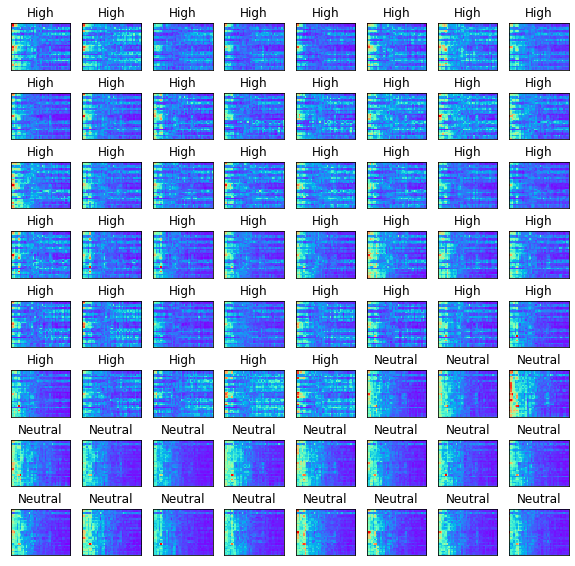

In [188]:
transform = transforms.Compose(
    [transforms.ToTensor()]) # H*W*C ndarray ==ToTensor()==> C*H*W tensor 
     #transforms.Normalize(train_mean, train_std)])
     #transforms.Normalize((0.5,), (0.5,))]) 

trainset = EEG_Dataset(train, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=2)

testset = EEG_Dataset(test, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False, num_workers=2)


# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()

print(images.shape) # (16 * 5 * 65 * 125)  # (16 * 1 * 32 * 193)

base = (8, 8)

# ===plot =========================================
plt.figure(figsize=(10,10))
for i in range(0, bs): # image = (5, 65, 125)
    for ch in range(0, n_channel):
        frame = images[i][ch] # 65 * 125    # 32 * 193
        x_y = i//base[1], i%base[1]

        plt.subplot2grid(base, x_y)

        if numOfClass == 2:
            title_dict = {0:"Low", 1:"High"}
        elif numOfClass == 3:
            title_dict = {0:"Low", 1:"Neutral", 2:"High"}

        if model_type == "reg":
            plt.title("High" if labels[i].item() > 5 else "Low")
        else:
            plt.title(title_dict[labels[i].item()])
            
        fig = plt.imshow(frame, cmap='rainbow')

        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
# ==============================================